In [258]:
from utils import *
from scipy.stats import kstest, linregress
import pickle
import pandas as pd
import os
import matplotlib

from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

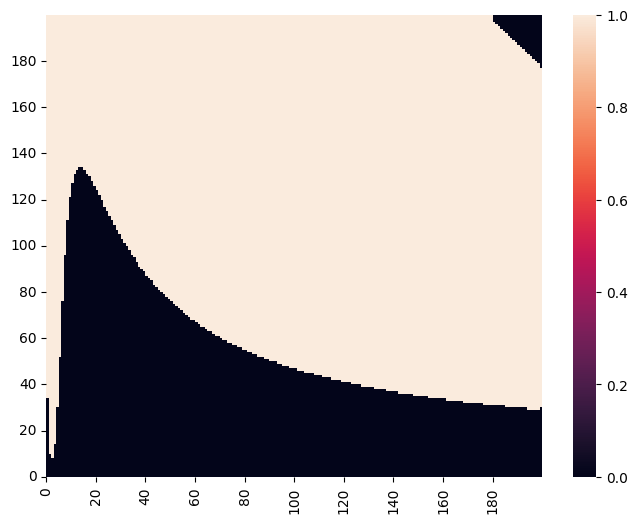

In [14]:
policy, params, _ = value_iteration(
    N=200,
    alpha=0.5,
    gamma=0.6,
    theta=0.88,
    omega=2.25,
    eta=0.88,
    beta=0.95,
    P_H_increase=0.9,
    invest_cost=1,
    health_delta=1,
    health_decrease_scale=1
)

plot_policy_boundary(policy, params)

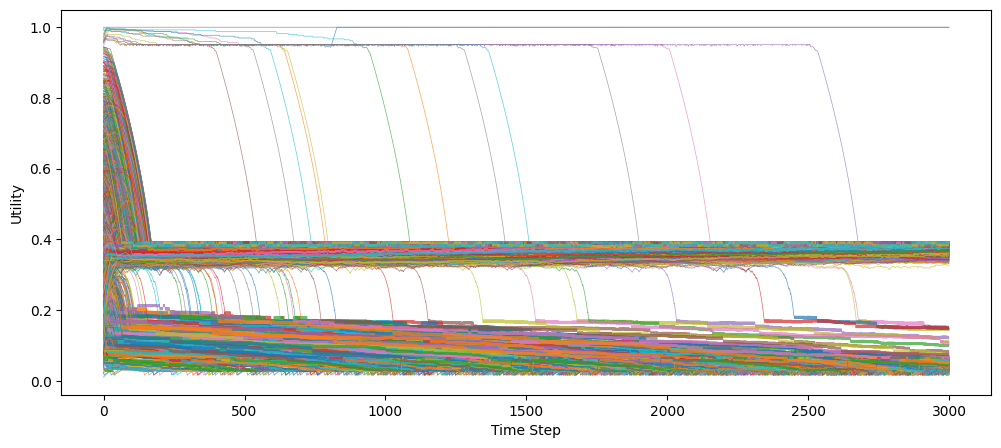

In [15]:
num_steps = 3000
num_agents = 2000

util, wealth, health = simulate(
    params,
    policy,
    num_steps,
    num_agents
)

plot_utility_trajectories(util)

# Steady State

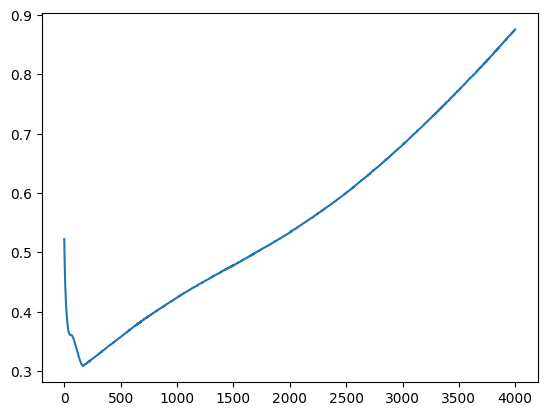

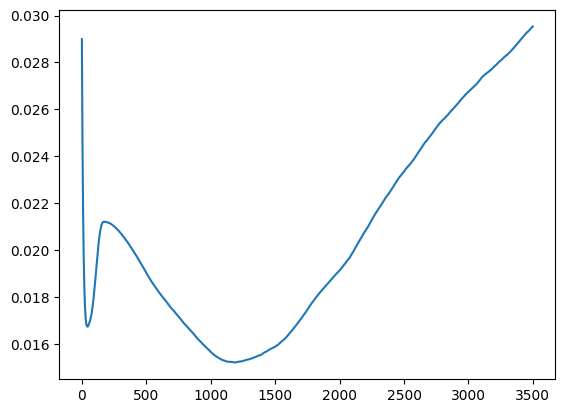

IndexError: index 0 is out of bounds for axis 0 with size 0

In [241]:
cv = np.std(util, axis=0) / np.mean(util, axis=0)
plt.plot(cv)
plt.show()

cv_std = [np.std(cv[i:i+500]) for i in range(len(cv)-500)]
plt.plot(cv_std)
plt.show()

print(np.where(np.array(cv_std) < 0.005)[0][0])

IndexError: index 0 is out of bounds for axis 0 with size 0

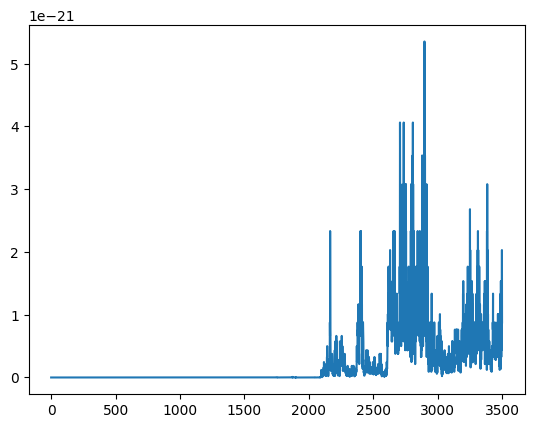

In [242]:
ks = [kstest(util[:,i], util[:,i+500]).pvalue for i in range(util.shape[1]-500)]
plt.plot(ks)
print(np.where(np.array(ks)>0.05)[0][0])

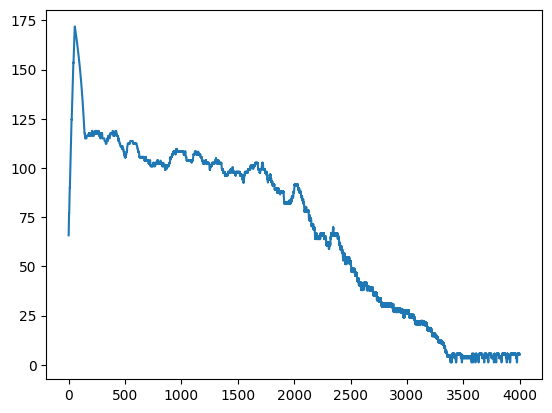

In [270]:
plt.plot(util[0,:])
plt.show()

In [282]:
window_size = 500
for i in range(len(util[0,:]) - window_size):
    interval = util[0, i:i+window_size]
    slope, intercept, r_value, p_value, std_err = linregress(np.linspace(0, window_size, window_size), interval)
    if p_value >= 0.05:
        print(i)
        break

568


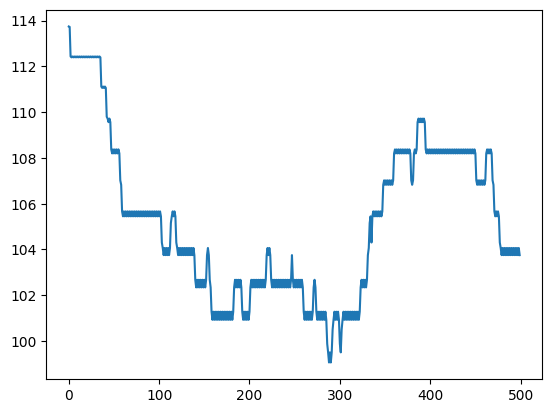

In [284]:
plt.plot(interval)
plt.show()

# Results

In [243]:
filepath = "results/0.24535567345863563_1_3_1.0.pickle"
with open(filepath, "rb") as f:
    res = pickle.load(f)

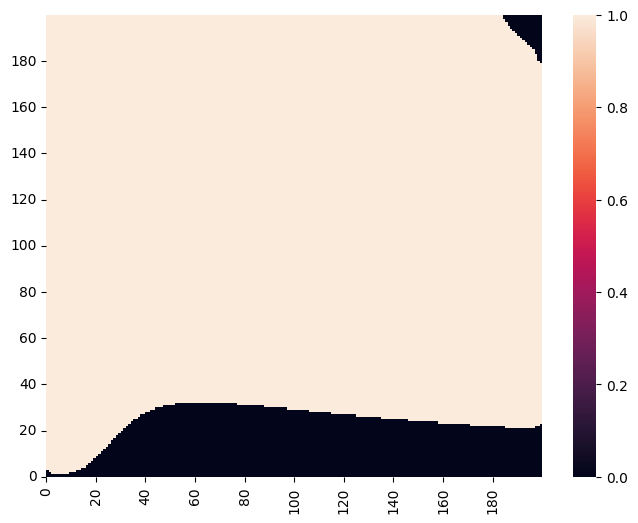

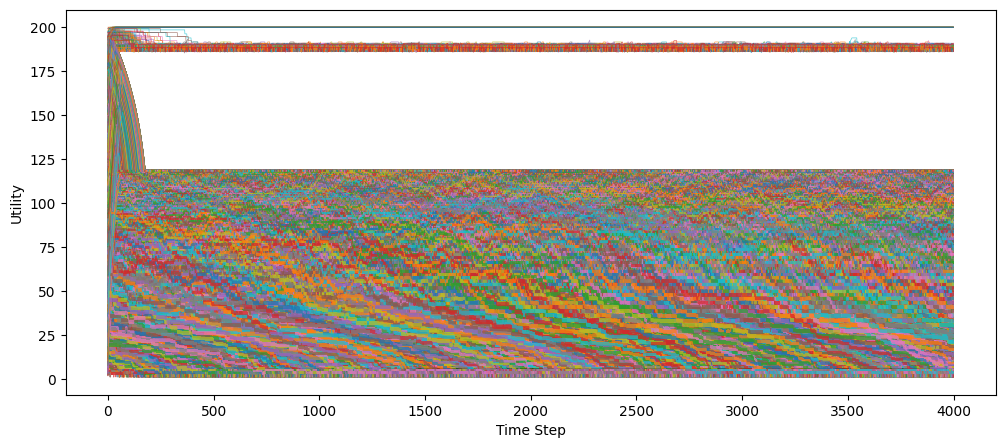

In [235]:
util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
plot_policy_boundary(res["policy"], res["params"])
plot_utility_trajectories(util)

In [239]:
# # Assuming `res` contains the data as described.
# time_steps = range(0, 400, 2)
# frames = []

# for T in time_steps:
#     wealth = res["wealth"][:, T]
#     health = res["health"][:, T]
    
#     x = np.linspace(min(wealth), max(wealth), 100)
#     y = np.linspace(min(health), max(health), 100)
#     X, Y = np.meshgrid(x, y)
    
#     positions = np.vstack([X.ravel(), Y.ravel()])
#     values = np.vstack([wealth, health])
#     kernel = gaussian_kde(values)
#     density = np.reshape(kernel(positions).T, X.shape)
    
#     # Create the 3D plot
#     fig = plt.figure(figsize=(8, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(X, Y, density, cmap='viridis', edgecolor='none')
    
#     ax.set_xlabel('Wealth')
#     ax.set_ylabel('Health')
#     ax.set_zlabel('Density')
#     ax.set_title(f'Time = {T}')
#     ax.set_xlim(0, 200)
#     ax.set_ylim(0, 200)
#     ax.view_init(elev=30, azim=45)
    
#     filename = f"animation/frame_{T}.png"
#     plt.savefig(filename)
#     frames.append(filename)
#     plt.close(fig)

# # Combine frames into a GIF
# images = [Image.open(frame) for frame in frames]
# gif_path = "3d_surface_animation.gif"
# images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)

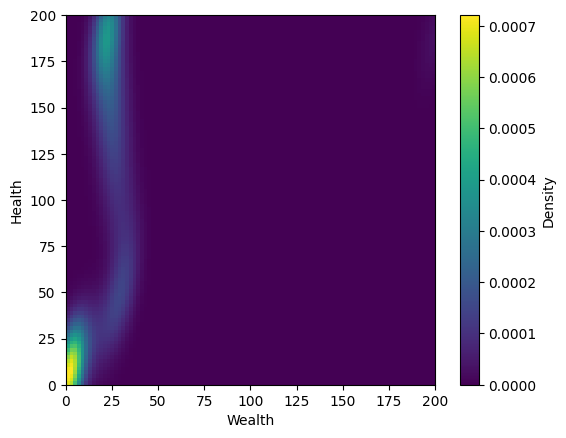

In [309]:
T = -1

wealth = res["wealth"][:, T]
health = res["health"][:, T]

x = np.linspace(min(wealth), max(wealth), 100)
y = np.linspace(min(health), max(health), 100)
X, Y = np.meshgrid(x, y)

positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([wealth, health])
kernel = gaussian_kde(values)
density = np.reshape(kernel(positions).T, X.shape)

plt.imshow(density, extent=[0, 200, 0, 200], origin='lower', cmap='viridis')
plt.colorbar(label="Density")
plt.xlabel("Wealth")
plt.ylabel("Health")
plt.show()

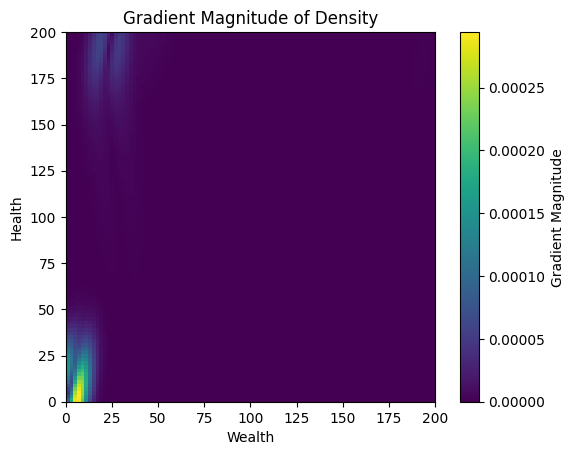

In [301]:
grad_wealth, grad_health = np.gradient(density, 1, 1)
gradient_magnitude = np.sqrt(grad_wealth**2 + grad_health**2)
plt.imshow(gradient_magnitude, extent=[0, 200, 0, 200], origin='lower', cmap='viridis')
plt.colorbar(label="Gradient Magnitude")
plt.xlabel("Wealth")
plt.ylabel("Health")
plt.title("Gradient Magnitude of Density")
plt.show()

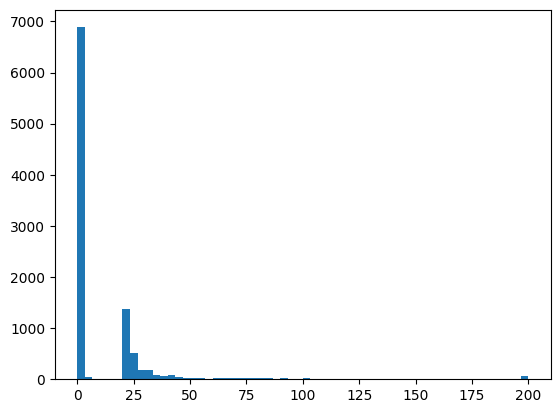

In [302]:
plt.hist(steady_wealth, bins=60)
plt.show()

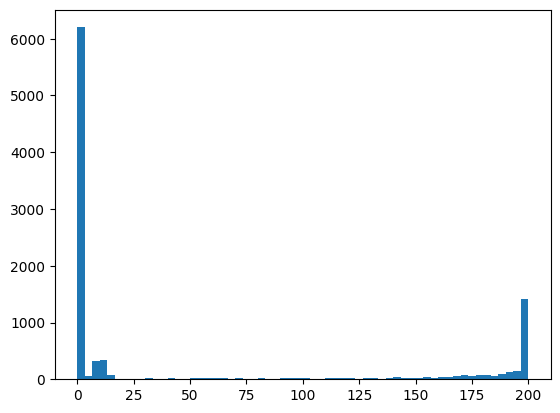

In [304]:
plt.hist(health, bins=60)
plt.show()